In [141]:
#Instalação de bibliotecas
!pip install xgboost
!pip install lightgbm

In [142]:
#Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, normaltest, mannwhitneyu, chi2_contingency, spearmanr
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [143]:
#Freedman-Diaconis
def freedman_diaconis(df):
    q75, q25 = np.percentile(df.dropna(), [75, 25])
    iqr = q75 - q25
    bins_width = 2 * iqr * len(df.dropna())**(-1/3)
    bins = int((df.dropna().max() - df.dropna().min()) / bins_width)
    return bins

In [144]:
#V de Cramers
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [145]:
#Extrair dados do banco
conn = sqlite3.connect('database/churn.db')

df = pd.read_sql_query("SELECT * FROM Churn", conn)

conn.close()

In [146]:
#Exploração do dataset

#5 primeiros itens
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [147]:
#Formato e Tamanho
print('Formato: ', df.shape)
print('Tamanho: ', df.size)

Formato:  (7043, 21)
Tamanho:  147903


In [148]:
#Tipos
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [149]:
#Nulos e duplicatas
print('Nulos:\n', df.isnull().sum())

print('\nDuplicatas: ', df.duplicated().sum())

Nulos:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Duplicatas:  0


In [150]:
#Verificar nulos ocultos em TotalCharges
mask = df['TotalCharges'].str.strip() == ''
print('Linhas vazias: ', df[mask].shape[0])

#Converter para numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Linhas vazias:  11


In [151]:
#Teste de assimetria
print('Assimetria: ', df['TotalCharges'].dropna().skew())

Assimetria:  0.9616424997242504


In [152]:
#Definição dos bins com Freedman-Diaconis
bins = freedman_diaconis(df['TotalCharges'])

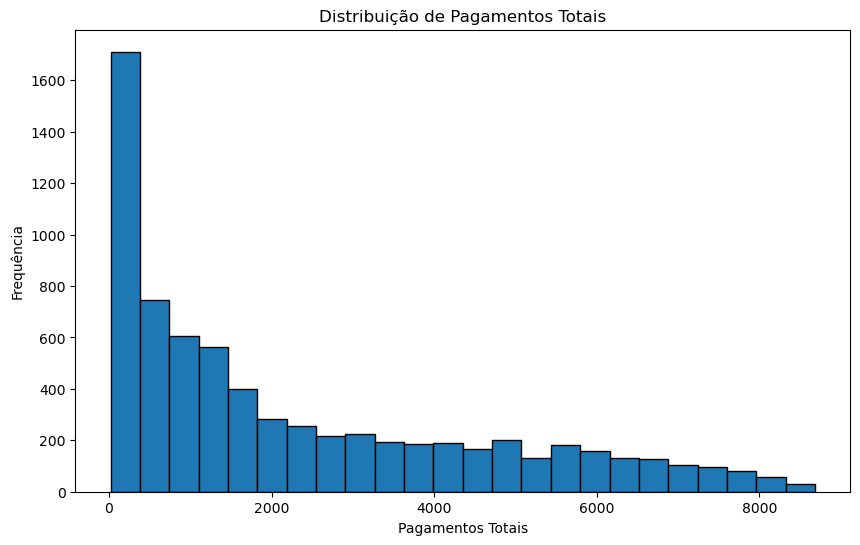

In [153]:
#Histograma
plt.figure(figsize=(10,6))
plt.hist(df['TotalCharges'].dropna(), bins=bins, edgecolor='black')
plt.title('Distribuição de Pagamentos Totais')
plt.xlabel('Pagamentos Totais')
plt.ylabel('Frequência')
plt.show()

In [154]:
#Preenchendo nulos com a mediana
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

Assimetria : 0.2395397495619829


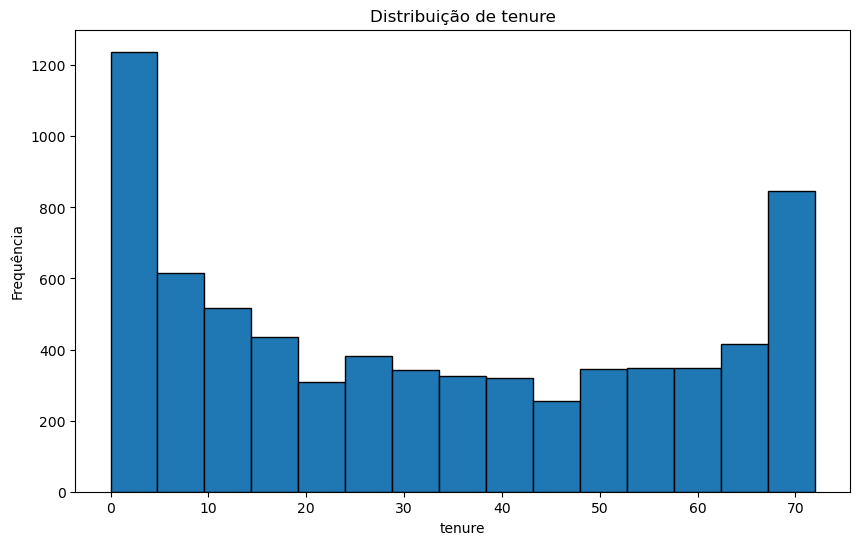

Assimetria : -0.22052443394398033


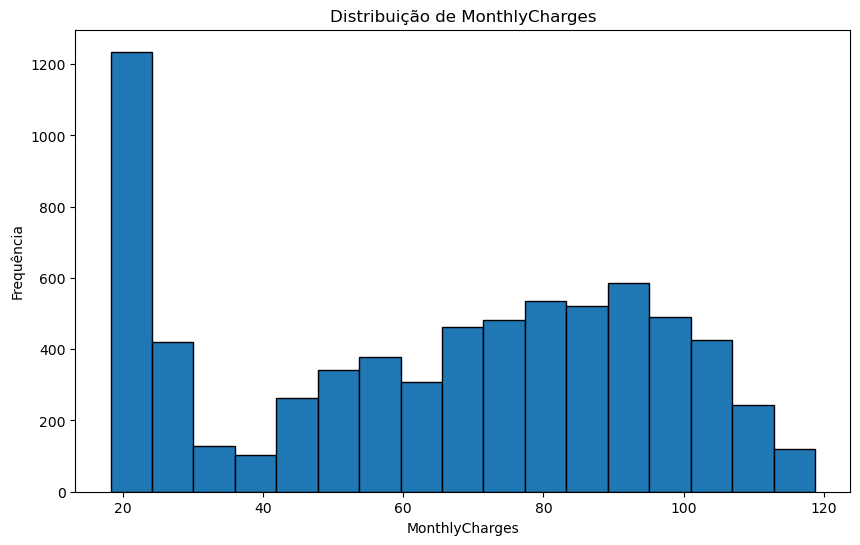

Assimetria : 0.9637890936414893


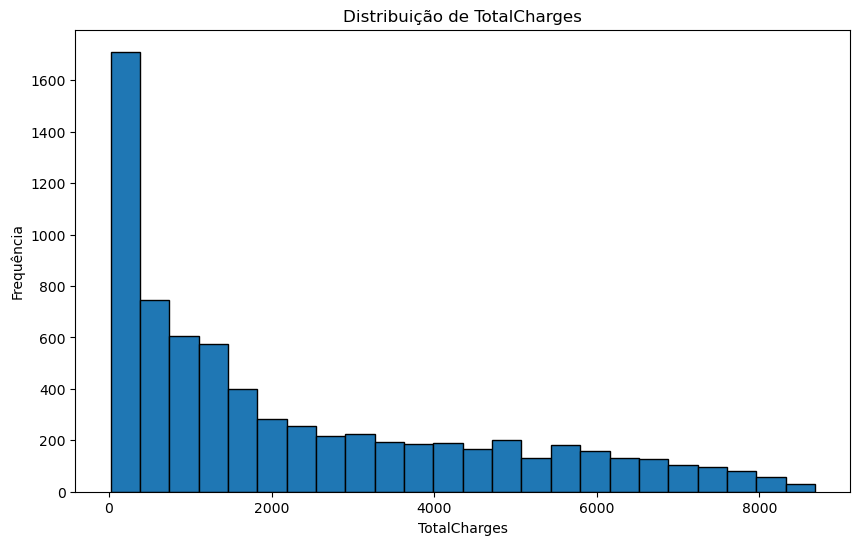

In [155]:
#Distribuição e assimetria para variáveis numéricas
numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

for var in numericas:
    print('Assimetria :', df[var].skew())
    bins = freedman_diaconis(df[var])

    plt.figure(figsize=(10,6))
    plt.hist(df[var], bins=bins, edgecolor='black')
    plt.title(f'Distribuição de {var}')
    plt.xlabel(f'{var}')
    plt.ylabel('Frequência')
    plt.show()

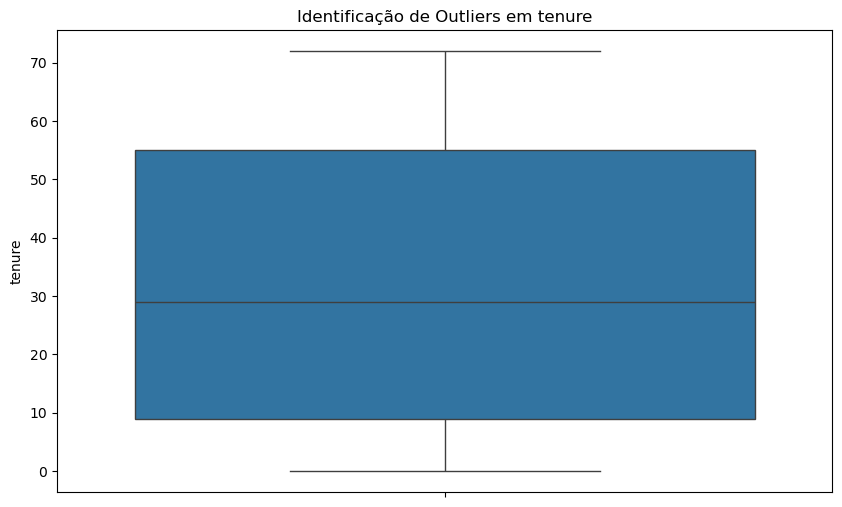

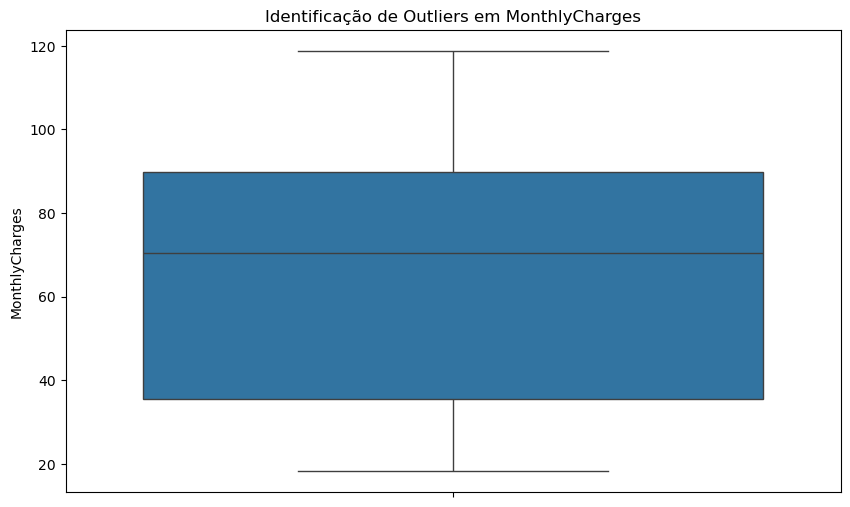

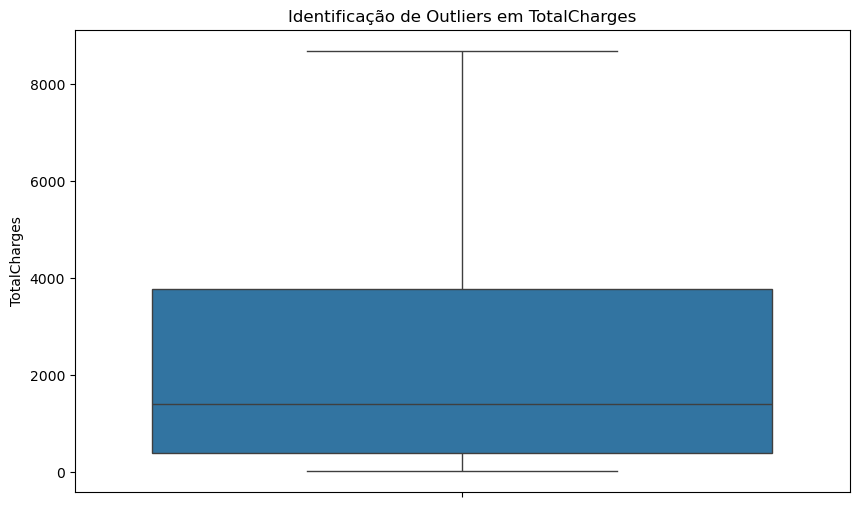

In [156]:
#Boxplot para variáveis numéricas

for var in numericas:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, y=var)
    plt.title(f'Identificação de Outliers em {var}')
    plt.show()

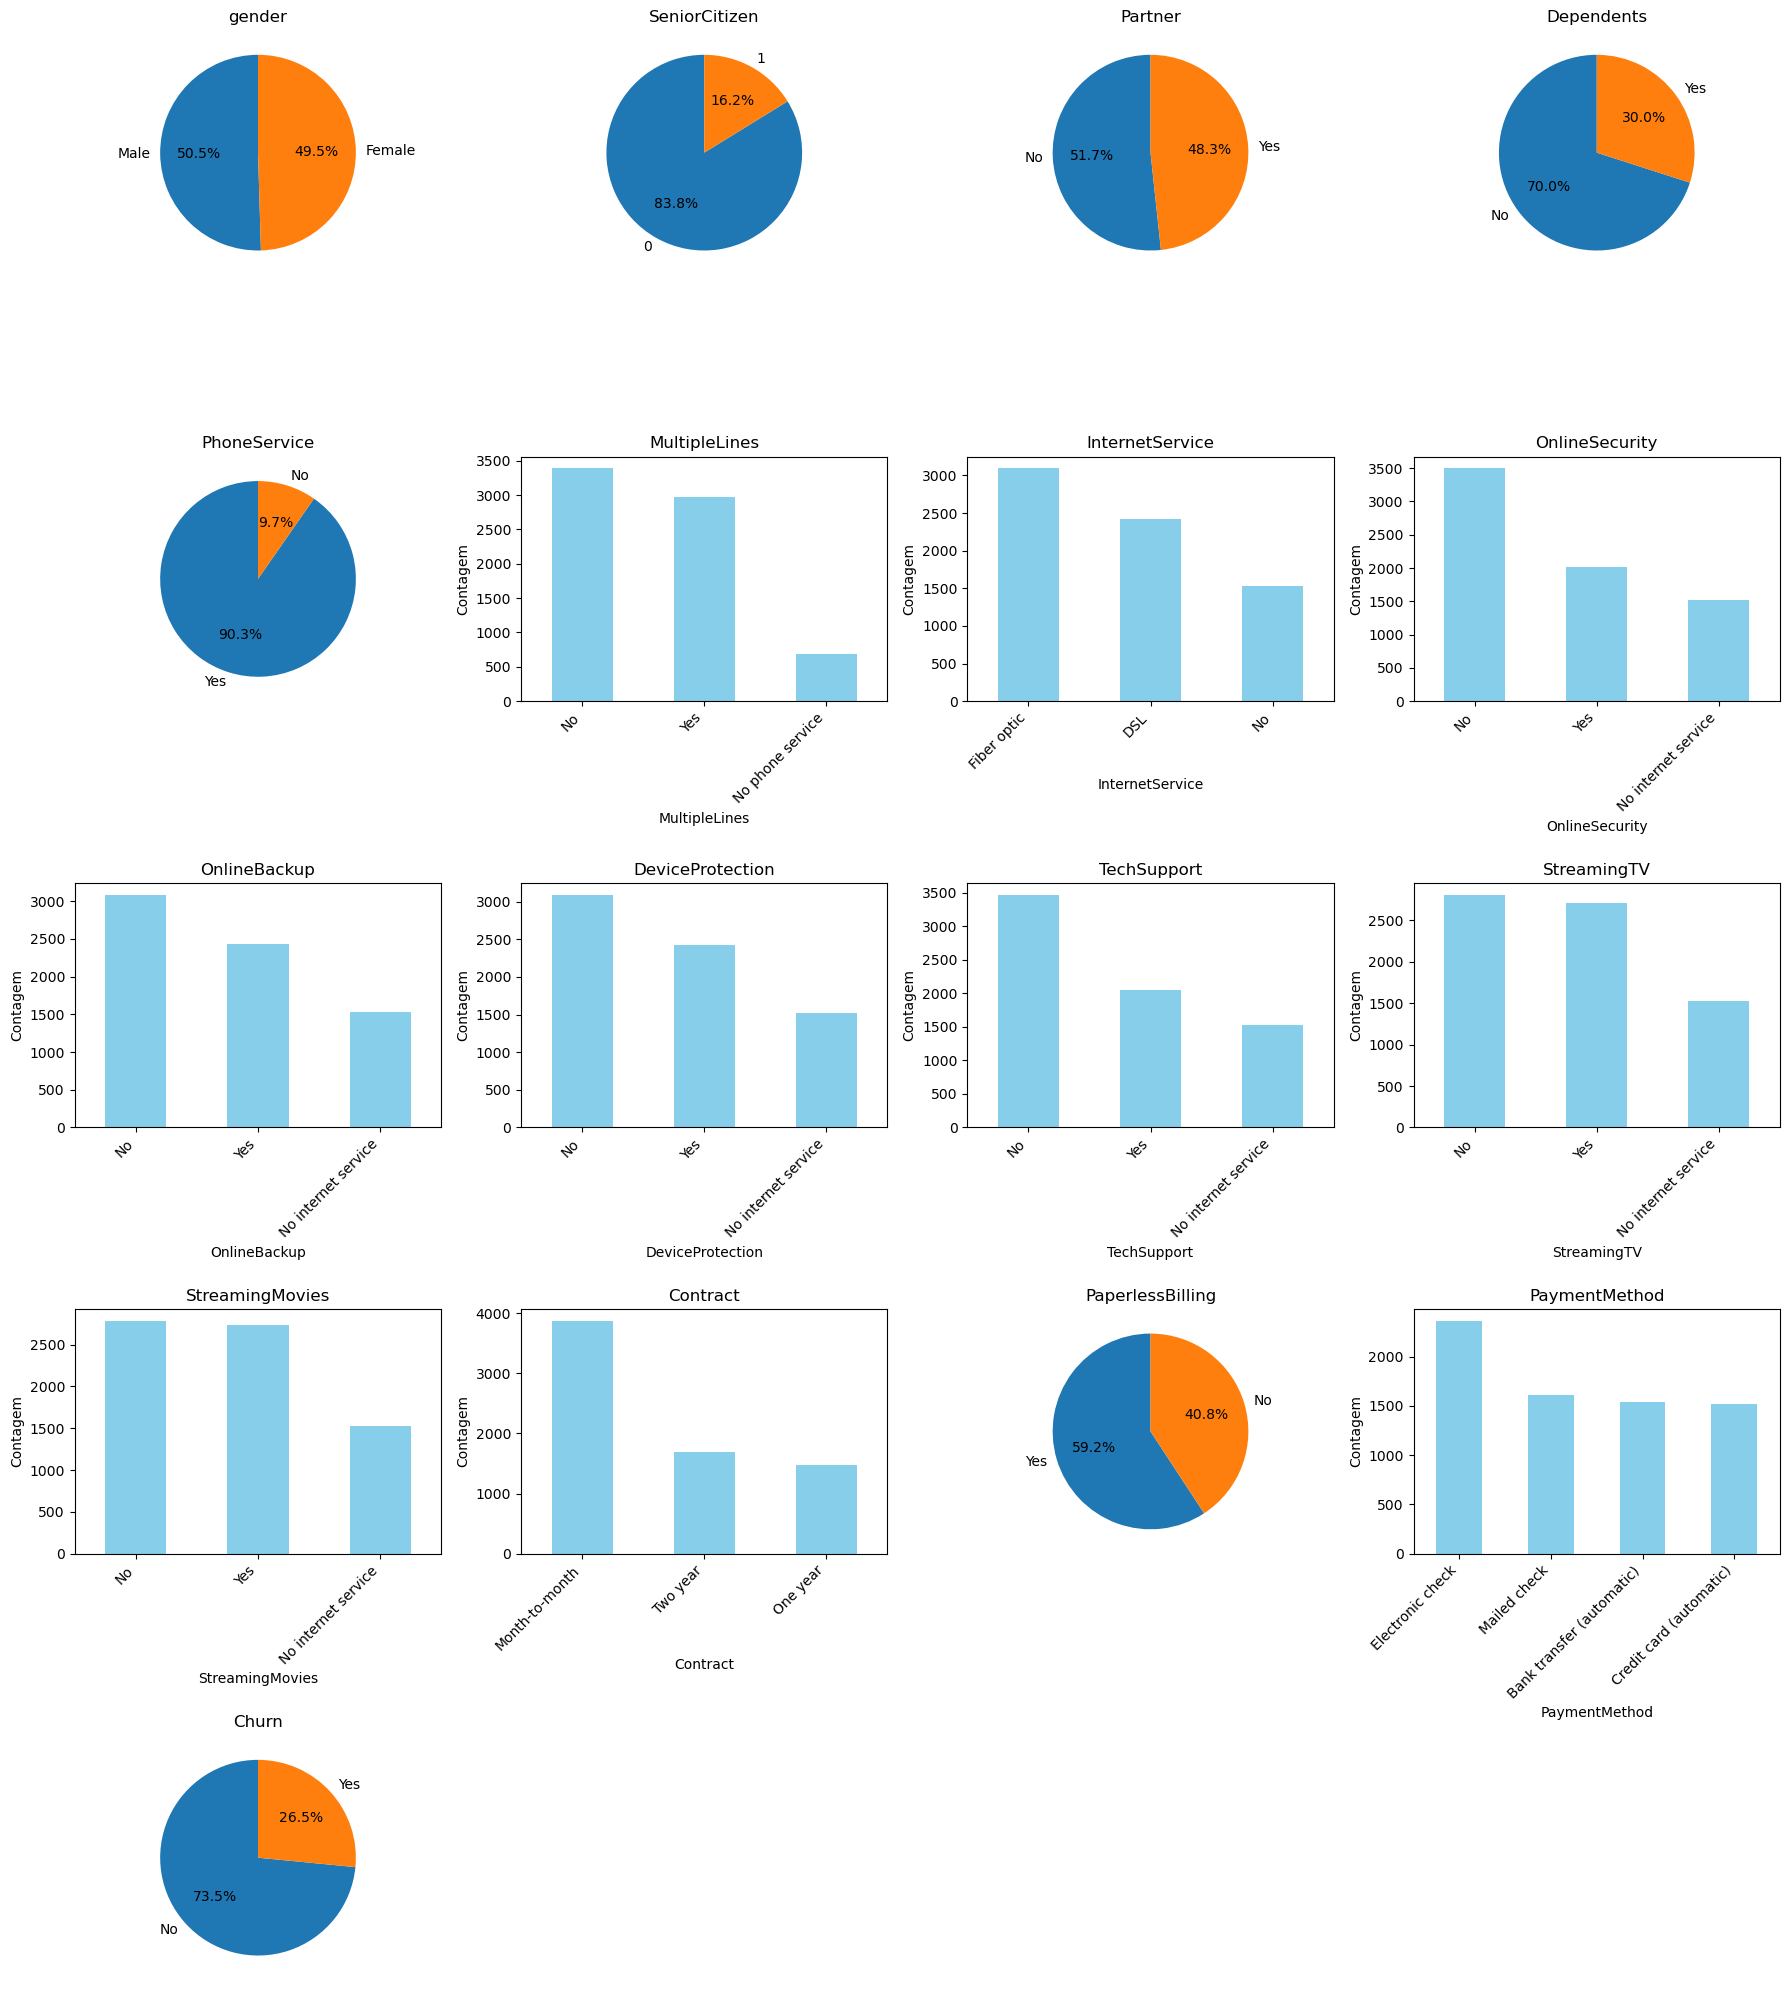

In [157]:
#Exploração das variáveis categóricas
categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
               'PhoneService', 'MultipleLines', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

n_col = 4
n_linhas = -(-len(categoricas) // n_col)
fig, axes = plt.subplots(n_linhas, n_col, figsize=(18, n_linhas * 4))
axes = axes.flatten()

for i, var in enumerate(categoricas):
    counts = df[var].value_counts()

    if len(counts) == 2:
        counts.plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            ax=axes[i],
            textprops={'fontsize':10}
        )
        axes[i].set_ylabel('')

    else:
        counts.plot.bar(
            ax=axes[i],
            color='skyblue'
        )
        axes[i].set_ylabel('Contagem')
        axes[i].set_xticklabels(counts.index, rotation=45, ha='right')

    axes[i].set_title(var, fontsize=12)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

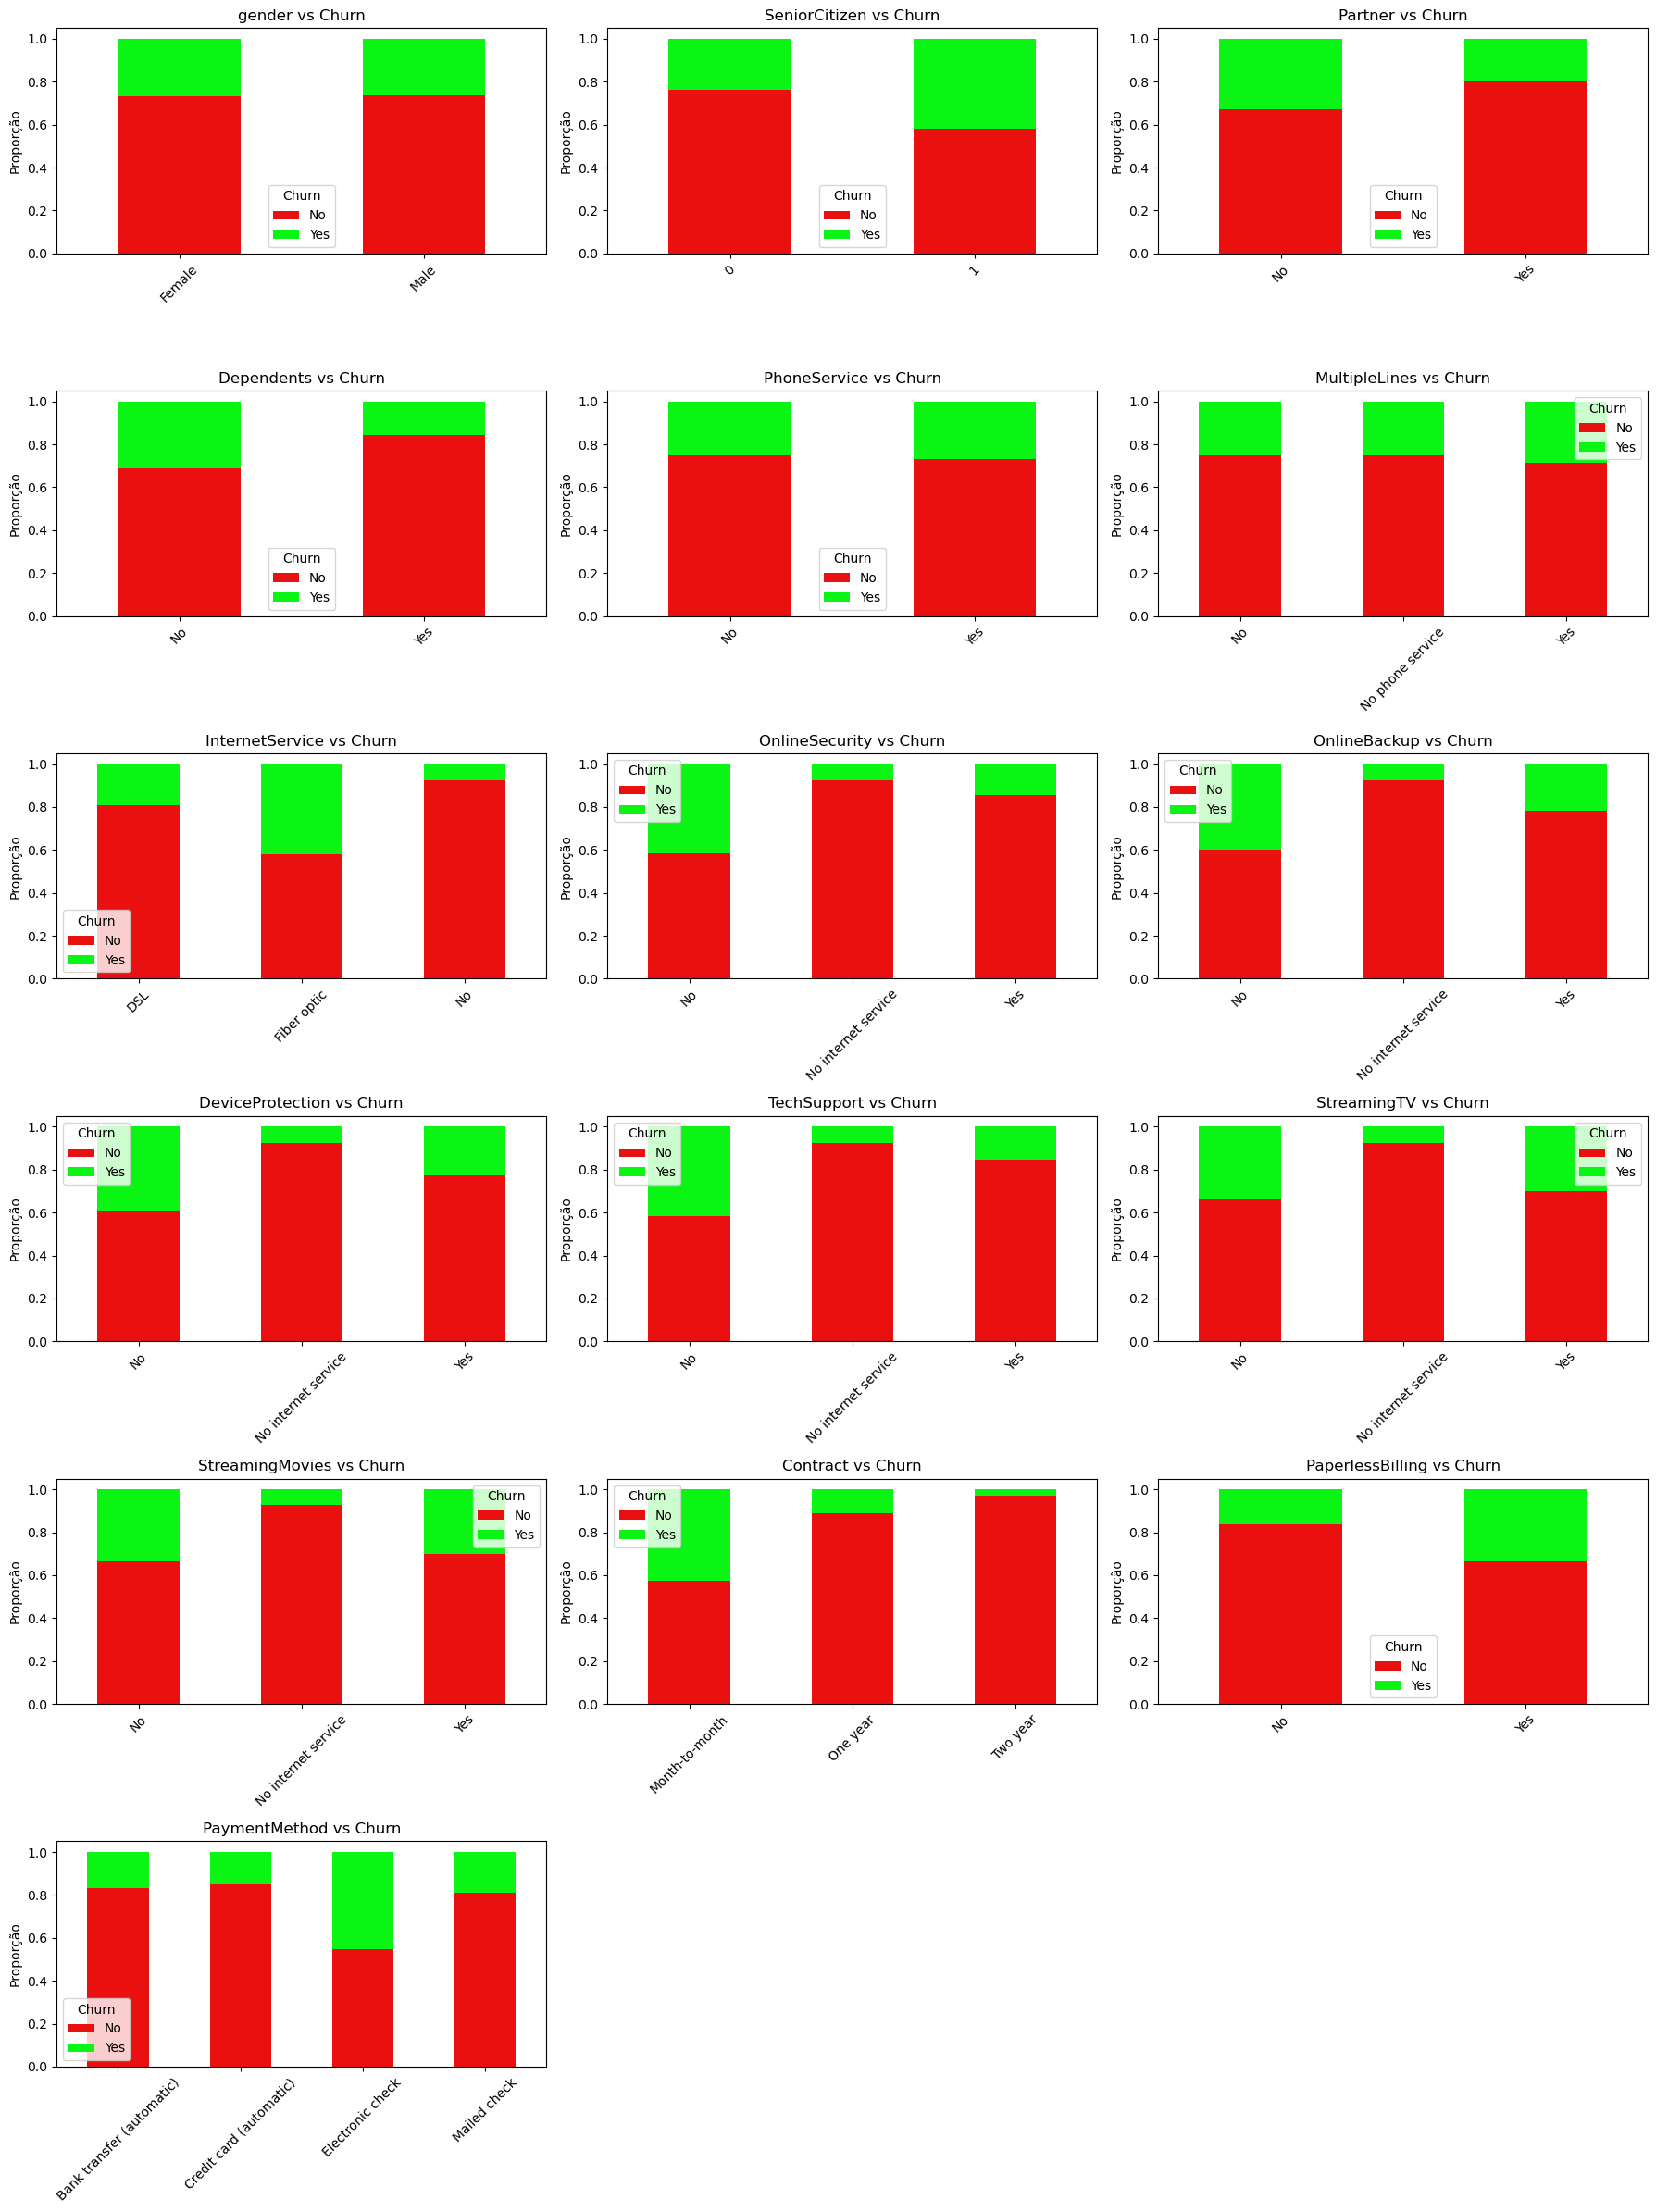

In [158]:
#Categóricas vs Churn
categoricas.remove('Churn')

n_cols = 3
n_rows = -(-len(categoricas) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

#Loop pelos gráficos
for i, var in enumerate(categoricas):
    # Tabela de proporções normalizada
    tab = pd.crosstab(df[var], df['Churn'], normalize='index')

    # Gráfico empilhado
    tab.plot(kind='bar', stacked=True, ax=axes[i], color=['#EA1010','#0BF515'])
    axes[i].set_title(f'{var} vs Churn')
    axes[i].set_ylabel('Proporção')
    axes[i].legend(title='Churn')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

#Esconder gráficos não usados (se sobrarem)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

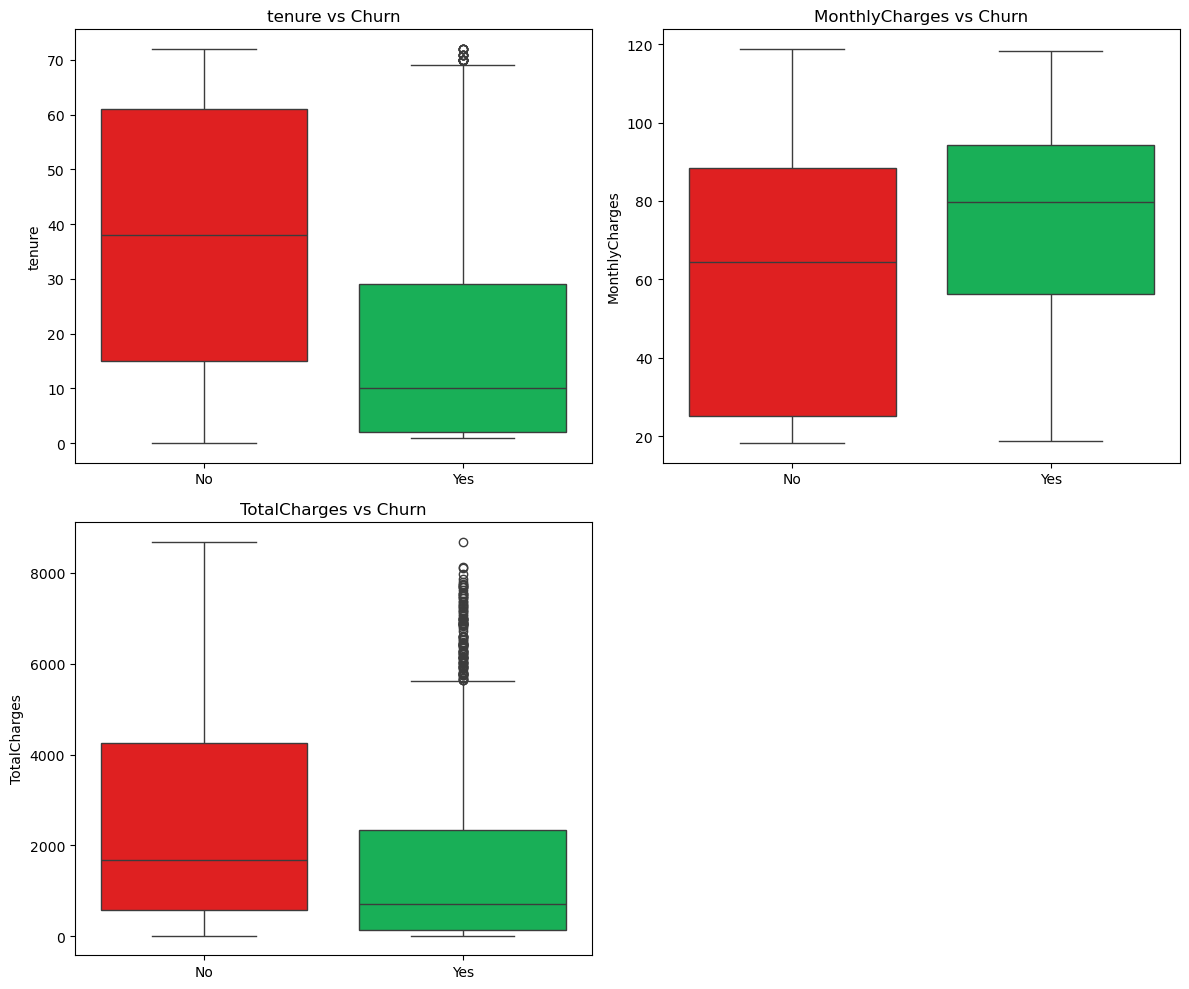

In [159]:
#Proporção de churn (cancelamento) para variáveis numéricas
palette = {'No': '#FF0001', 'Yes': '#00C853'}

n_cols = 2
n_rows = -(-len(numericas) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numericas):
    sns.boxplot(x='Churn', y=var, data=df, ax=axes[i], hue='Churn', palette=palette)
    axes[i].set_title(f'{var} vs Churn', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(var)

#Esconde os eixos extras se sobrar
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [160]:
#Relação entre churn (cancelamento) e variáveis numéricas

#Teste de normalidade
for var in numericas:
    print(f'\n {var} - Teste de Normalidade (D\'Agostino-Pearson):')
    for group in ['Yes', 'No']:
        stat, p = normaltest(df[df['Churn'] == group][var])
        print(f'Churn = {group} -> p-valor: {p:.4f} {"(normal)" if p > 0.05 else "(não normal)"}')


 tenure - Teste de Normalidade (D'Agostino-Pearson):
Churn = Yes -> p-valor: 0.0000 (não normal)
Churn = No -> p-valor: 0.0000 (não normal)

 MonthlyCharges - Teste de Normalidade (D'Agostino-Pearson):
Churn = Yes -> p-valor: 0.0000 (não normal)
Churn = No -> p-valor: 0.0000 (não normal)

 TotalCharges - Teste de Normalidade (D'Agostino-Pearson):
Churn = Yes -> p-valor: 0.0000 (não normal)
Churn = No -> p-valor: 0.0000 (não normal)


In [161]:
#Mann-Whitney
for var in numericas:
    grupo_sim = df[df['Churn'] == 'Yes'][var]
    grupo_nao = df[df['Churn'] == 'No'][var]
    stat, p = mannwhitneyu(grupo_sim, grupo_nao, alternative='two-sided')
    print(f'\n{var} - Teste de Mann-Whitney U')
    print(f'Estatistica U = {stat:.2f} | p-valor: {p:.2f}')
    if p < 0.05:
        print('Diferença significativa entre churn e não churn')
    else:
        print('Sem diferença significativa')


tenure - Teste de Mann-Whitney U
Estatistica U = 2515538.00 | p-valor: 0.00
Diferença significativa entre churn e não churn

MonthlyCharges - Teste de Mann-Whitney U
Estatistica U = 6003125.50 | p-valor: 0.00
Diferença significativa entre churn e não churn

TotalCharges - Teste de Mann-Whitney U
Estatistica U = 3367925.00 | p-valor: 0.00
Diferença significativa entre churn e não churn


In [162]:
#Correlação de Spearman
for var in numericas:
    corr, p_value = spearmanr(df[var], df['Churn'])
    print(f"Correlação de Spearman para {var} vs. Churn: {corr:.4f}\n p-valor: {p_value:.4f}")

Correlação de Spearman para tenure vs. Churn: -0.3671
 p-valor: 0.0000
Correlação de Spearman para MonthlyCharges vs. Churn: 0.1847
 p-valor: 0.0000
Correlação de Spearman para TotalCharges vs. Churn: -0.2321
 p-valor: 0.0000


In [163]:
#Relação entre churn (cancelamento) e variáveis categóricas

#Qui-quadrado para categóricas
cat_var = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
            'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod']

for var in cat_var:
    tabela = pd.crosstab(df[var], df['Churn'])
    chi2, p, dof, _ = chi2_contingency(tabela)
    print(f'{var}: p-valor = {p:.4f} {"→ associação significativa" if p < 0.05 else "→ sem associação significativa"}')

gender: p-valor = 0.4866 → sem associação significativa
SeniorCitizen: p-valor = 0.0000 → associação significativa
Partner: p-valor = 0.0000 → associação significativa
Dependents: p-valor = 0.0000 → associação significativa
PhoneService: p-valor = 0.3388 → sem associação significativa
MultipleLines: p-valor = 0.0035 → associação significativa
InternetService: p-valor = 0.0000 → associação significativa
OnlineSecurity: p-valor = 0.0000 → associação significativa
OnlineBackup: p-valor = 0.0000 → associação significativa
DeviceProtection: p-valor = 0.0000 → associação significativa
TechSupport: p-valor = 0.0000 → associação significativa
StreamingTV: p-valor = 0.0000 → associação significativa
StreamingMovies: p-valor = 0.0000 → associação significativa
Contract: p-valor = 0.0000 → associação significativa
PaperlessBilling: p-valor = 0.0000 → associação significativa
PaymentMethod: p-valor = 0.0000 → associação significativa


In [164]:
#V de Cramer
for category in cat_var:
    contingency_table = pd.crosstab(df[category], df['Churn'])
    v_cramer = cramers_v(contingency_table)
    print(f"V de Cramer para {category} vs. Churn: {v_cramer:.4f}")

V de Cramer para gender vs. Churn: 0.0083
V de Cramer para SeniorCitizen vs. Churn: 0.1505
V de Cramer para Partner vs. Churn: 0.1501
V de Cramer para Dependents vs. Churn: 0.1639
V de Cramer para PhoneService vs. Churn: 0.0114
V de Cramer para MultipleLines vs. Churn: 0.0401
V de Cramer para InternetService vs. Churn: 0.3225
V de Cramer para OnlineSecurity vs. Churn: 0.3474
V de Cramer para OnlineBackup vs. Churn: 0.2923
V de Cramer para DeviceProtection vs. Churn: 0.2816
V de Cramer para TechSupport vs. Churn: 0.3429
V de Cramer para StreamingTV vs. Churn: 0.2305
V de Cramer para StreamingMovies vs. Churn: 0.2310
V de Cramer para Contract vs. Churn: 0.4101
V de Cramer para PaperlessBilling vs. Churn: 0.1915
V de Cramer para PaymentMethod vs. Churn: 0.3034


In [175]:
#Preparação de dados para o modelo
df = df.drop('customerID', axis=1)

#Transformação de churn (cancelamento)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

#Separar categórias relevantes
cat_rel = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

#Separar numéricas relevantes
num_rel = ['tenure', 'TotalCharges']

In [180]:
#Dados de treino
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Proporção de Churn no y_train: {y_train.value_counts(normalize=True)}")
print(f"Proporção de Churn no y_test: {y_test.value_counts(normalize=True)}")

Shape de X_train: (5634, 19)
Shape de X_test: (1409, 19)
Proporção de Churn no y_train: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Proporção de Churn no y_test: Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [181]:
#Pré-processamento
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#Scaler
X_train_scaled = scaler.fit_transform(X_train[num_rel])
X_test_scaled = scaler.transform(X_test[num_rel])

X_train_encoded = encoder.fit_transform(X_train[cat_rel])
X_test_encoded = encoder.transform(X_test[cat_rel])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_rel, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_rel, index=X_test.index)

#OneHotEncoder
encoded_feature_names = encoder.get_feature_names_out(cat_rel)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

X_train_processed = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_processed = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

print(f"\nShape de X_train_processed: {X_train_processed.shape}")
print(f"Shape de X_test_processed: {X_test_processed.shape}")
print("\nPrimeiras 5 linhas de X_train_processed (amostra):\n", X_train_processed.head())


Shape de X_train_processed: (5634, 30)
Shape de X_test_processed: (1409, 30)

Primeiras 5 linhas de X_train_processed (amostra):
         tenure  TotalCharges  InternetService_DSL  \
2986  0.905559      0.680532                  0.0   
6406  0.257588     -0.171516                  1.0   
6409  0.419581     -0.668156                  0.0   
5322 -0.268888     -0.095359                  1.0   
6913  1.472534      2.286128                  0.0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_No  \
2986                          1.0                 0.0                1.0   
6406                          0.0                 0.0                1.0   
6409                          0.0                 1.0                0.0   
5322                          0.0                 0.0                1.0   
6913                          1.0                 0.0                1.0   

      OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No  \
2986        

In [183]:
#Regressão logística
log_model = LogisticRegression(solver='liblinear', random_state=40)

log_model.fit(X_train_processed, y_train)
print("Modelo de Regressão Logística treinado com sucesso.")

y_pred_log_no_smote = log_model.predict(X_test_processed)
y_prob_log_no_smote = log_model.predict_proba(X_test_processed)[:, 1]

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_log_no_smote))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_log_no_smote))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob_log_no_smote))

Modelo de Regressão Logística treinado com sucesso.

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


Matriz de Confusão:
 [[915 120]
 [172 202]]

AUC-ROC Score: 0.8300976517089049


In [185]:
#XGBoost
xgb_model = XGBClassifier(enable_categorical=True, eval_metric='logloss', random_state=40)

xgb_model.fit(X_train_processed, y_train)
print("Modelo XGBoost treinado com sucesso.")

y_pred_xgb_no_smote = xgb_model.predict(X_test_processed)
y_prob_xgb_no_smote = xgb_model.predict_proba(X_test_processed)[:, 1]

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_xgb_no_smote))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb_no_smote))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob_xgb_no_smote))

Modelo XGBoost treinado com sucesso.

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      1035
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409


Matriz de Confusão:
 [[890 145]
 [180 194]]

AUC-ROC Score: 0.8141762897517373


In [186]:
#SMOTE
smote = SMOTE(random_state=40)

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f'\nShape de X_train_smote: {X_train_smote.shape}')
print(f'Proporção de Churn no y_train_smote: {y_train_smote.value_counts(normalize=True)}')


Shape de X_train_smote: (8278, 30)
Proporção de Churn no y_train_smote: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [187]:
#Regressão logística com SMOTE
log_model = LogisticRegression(solver='liblinear', random_state=40)
log_model.fit(X_train_smote, y_train_smote)
print('Modelo de regressão treinado com sucesso')

#XGBoost com SMOTE
xgb_model = XGBClassifier(enable_categorical=True, eval_metric='logloss', random_state=40)
xgb_model.fit(X_train_smote, y_train_smote)
print('Modelo XGBoost treinado com sucesso')

Modelo de regressão treinado com sucesso
Modelo XGBoost treinado com sucesso


In [188]:
#Avaliação dos modelos com SMOTE

#Regressão logítisca
y_pred_log = log_model.predict(X_test_processed)
y_prob_log = log_model.predict_proba(X_test_processed)[:, 1]

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_log))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_log))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob_log))

#XGBoost
y_pred_xgb = xgb_model.predict(X_test_processed)
y_prob_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_xgb))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob_xgb))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


Matriz de Confusão:
 [[744 291]
 [ 77 297]]

AUC-ROC Score: 0.8288705469012375

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409


Matriz de Confusão:
 [[815 220]
 [128 246]]

AUC-ROC Score: 0.8095442920251105


In [189]:
#Hiperparâmetros para regressão logística (RL demonstrou melhor desempenho de recall)
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  #Valores para o inverso da força de regularização
    'penalty': ['l1', 'l2'],             #Tipos de penalidade (L1 para esparsidade, L2 para suavidade)
    'solver': ['liblinear', 'saga']      #Solvers que suportam L1 e L2
}

grid_search_log = GridSearchCV(estimator=log_model,
                               param_grid=param_grid_log,
                               cv=5, # 5-fold cross-validation
                               scoring='roc_auc', # Métrica para otimização
                               n_jobs=-1, # Usar todos os cores da CPU para acelerar
                               verbose=2) # Para ver o progresso

print("\nExecutando GridSearchCV para Regressão Logística....")
#Executar a busca em grade no conjunto de treino balanceado pelo SMOTE
grid_search_log.fit(X_train_smote, y_train_smote)

print("\nGridSearchCV concluído!")
print("Melhores hiperparâmetros encontrados:", grid_search_log.best_params_)
print("Melhor pontuação ROC_AUC (validação cruzada):", grid_search_log.best_score_)

#Obter o melhor modelo
best_log_model = grid_search_log.best_estimator_


Executando GridSearchCV para Regressão Logística....
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GridSearchCV concluído!
Melhores hiperparâmetros encontrados: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Melhor pontuação ROC_AUC (validação cruzada): 0.8549493189477868


In [191]:
#Avaliação do Melhor Modelo de regressão logística após o GridSearchCV
y_pred_best_log = best_log_model.predict(X_test_processed)
y_prob_best_log = best_log_model.predict_proba(X_test_processed)[:, 1]

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_best_log))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_best_log))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob_best_log))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


Matriz de Confusão:
 [[743 292]
 [ 77 297]]

AUC-ROC Score: 0.8289144643364591


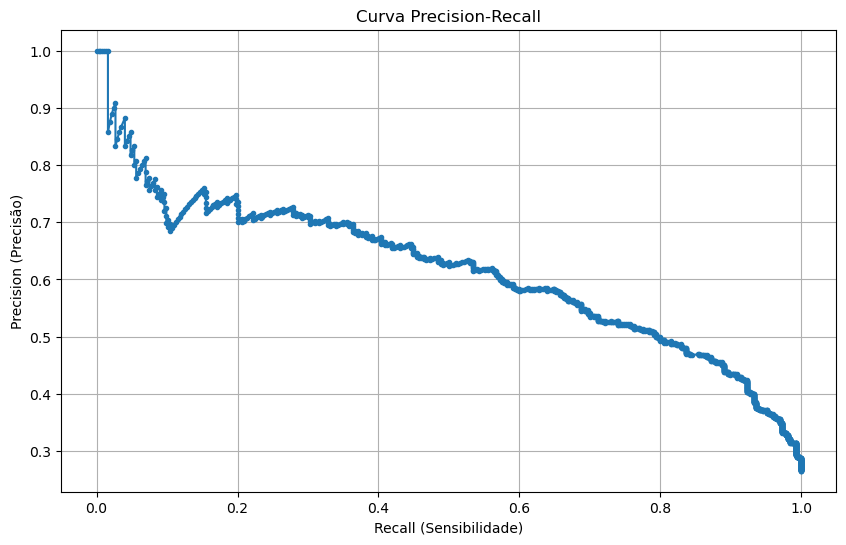

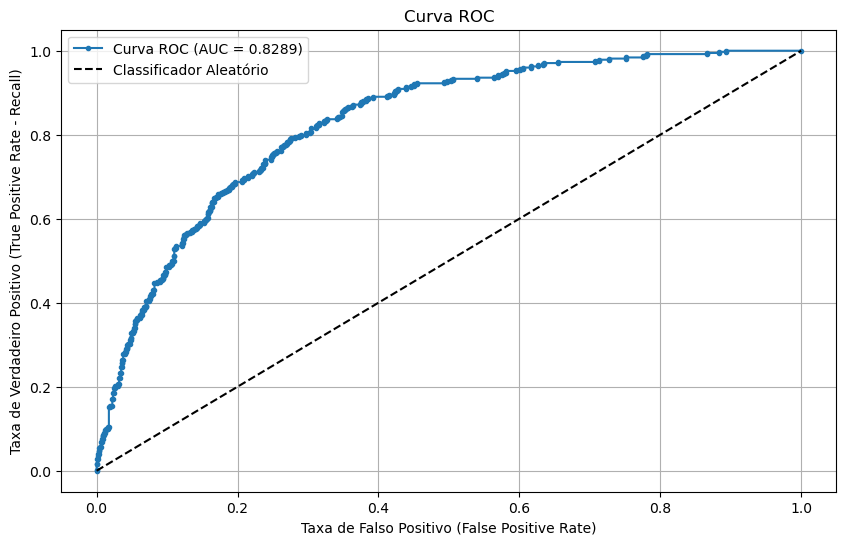

In [192]:
#Curvas de Precision-Recall e ROC no modelo de regressão logística

#Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_best_log)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.grid(True)
plt.show()

#ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob_best_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.4f})', marker='.')
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório') # Linha de base aleatória
plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate - Recall)')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
#Novo limiar para o modelo de regressão logística
new_threshold = 0.35

#Prever classes usando o novo limiar
y_pred_new_threshold = (y_prob_best_log >= new_threshold).astype(int)

#Reavaliar o modelo com o novo limiar
print("\nRelatório de Classificação (Novo Limiar):\n", classification_report(y_test, y_pred_new_threshold))
print("\nMatriz de Confusão (Novo Limiar):\n", confusion_matrix(y_test, y_pred_new_threshold))
print("\nAUC-ROC Score:\n", roc_auc_score(y_test, y_prob_best_log))


Relatório de Classificação (Novo Limiar):
               precision    recall  f1-score   support

           0       0.94      0.58      0.72      1035
           1       0.44      0.90      0.59       374

    accuracy                           0.66      1409
   macro avg       0.69      0.74      0.65      1409
weighted avg       0.81      0.66      0.68      1409


Matriz de Confusão (Novo Limiar):
 [[601 434]
 [ 39 335]]

AUC-ROC Score:
 0.8289144643364591
